In [3]:
# !pip install nltk
# !pip install scikit-learn
# !pip install scipy



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Working with the dataset

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader


In [2]:
# \t 기준으로 나눠서 csv로 불러오기
data=pd.read_csv("ml-100k/u.data",sep="\t",header=None)

In [3]:
#마지막 열 제거
data=data.iloc[:,:-1]

In [4]:
#열 이름 설정
data.columns=['user_id','item_id','rating']

In [5]:
data.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Text(0, 0.5, 'freq')

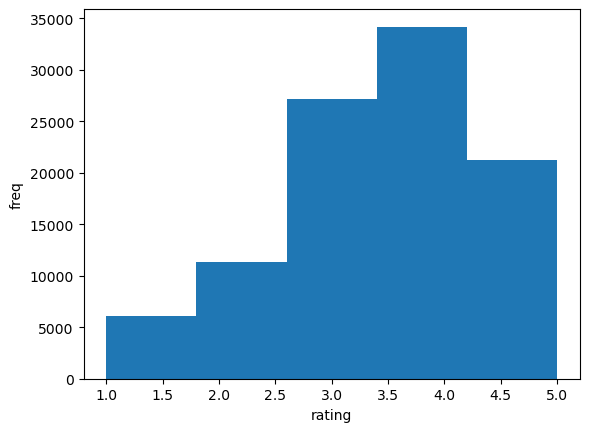

In [111]:
plt.hist(data['rating'],bins=5)
plt.xlabel('rating')
plt.ylabel('freq')

In [112]:
# Dataframe을 matrix로 변환
def dataframe2matrix(data,row_title,col_title,data_title,default_value=0):
    matrix=data.pivot(index=row_title,columns=col_title,values=data_title)
    matrix=matrix.fillna(default_value)
    return matrix

In [113]:
user_item_matrix=dataframe2matrix(data, 'user_id','item_id','rating')

Data partitions

In [115]:
# 데이터 분할
train, test = train_test_split(data, test_size=0.3, random_state=0)

In [116]:
# Suprise 형식으로 데이터 로드
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(train[['user_id','item_id','rating']],reader)
test_data = Dataset.load_from_df(test[['user_id','item_id','rating']],reader)

Integrating a popularity Recommender

In [117]:
avg_top3 = train.groupby('item_id')['rating'].mean().nlargest(3)
print("평균 평점이 높은 영화: ", avg_top3)
print("\n")
freq_top3 = train['item_id'].value_counts().nlargest(3)
print("평가 횟수가 가장 높은 영화: ",freq_top3)
print("\n")
C=train.groupby('item_id')['rating'].agg(['mean','count'])
avg_freq_top3=C[C['count']>50]['mean'].nlargest(3)
print("평점도 가장 높고 평균평점도 높은 영화: ",avg_freq_top3)

평균 평점이 높은 영화:  item_id
119     5.0
814     5.0
1189    5.0
Name: rating, dtype: float64


평가 횟수가 가장 높은 영화:  item_id
50     410
181    367
100    353
Name: count, dtype: int64


평점도 가장 높고 평균평점도 높은 영화:  item_id
318    4.472477
408    4.467532
64     4.462366
Name: mean, dtype: float64


Integrating a collaborative filtering recommender(UBCF)

In [118]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [119]:
# 데이터 준비
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data[['user_id','item_id','rating']],reader)

In [120]:
# 데이터 분할
trainset, testset = train_test_split(data, test_size=0.25)

In [121]:
# UBCF 모델 생성 및 훈련
algo = KNNBasic(sim_options={'user_based': True})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [122]:
# 테스트 데이터에 대한 예측 수행
predictions = algo.test(testset)

In [123]:
# RMSE(평균 제곱근 오차) 계산
accuracy.rmse(predictions)

RMSE: 0.9794


0.9794131519528506

In [124]:
# 모델 평가(5겹 교차검증)
predictions_ubcf_accuracy=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9795  0.9812  0.9749  0.9789  0.9832  0.9795  0.0028  
MAE (testset)     0.7737  0.7750  0.7678  0.7753  0.7768  0.7737  0.0031  
Fit time          0.48    0.50    0.50    0.50    0.50    0.50    0.01    
Test time         2.72    2.53    2.52    2.50    2.60    2.57    0.08    


In [125]:
y_true = [1 if prediction.r_ui >= 4 else 0 for prediction in predictions]
y_scores = [prediction.est for prediction in predictions]

Text(0, 0.5, 'True Positive Rate')

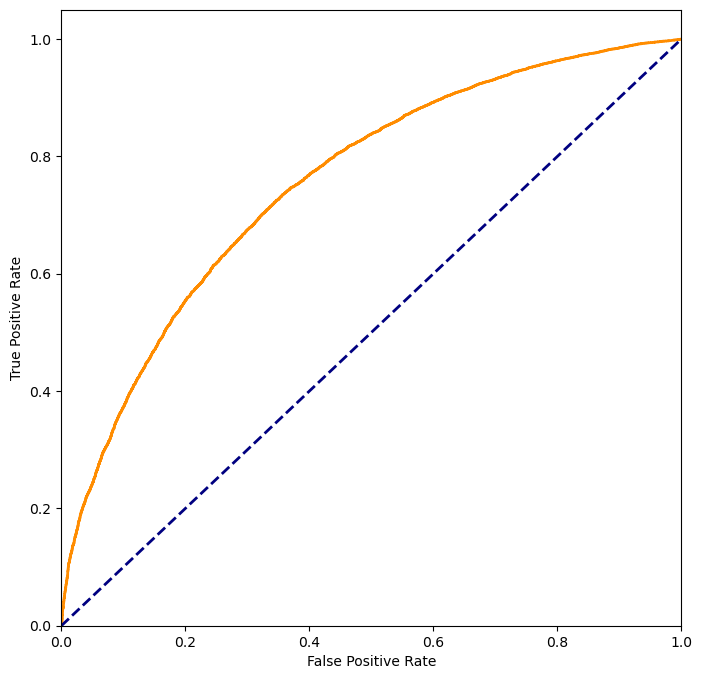

In [126]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# roc 곡선 아래 면적
roc_auc = auc(fpr, tpr)

# ROC curve 그래프
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Integrating an item-similarity recommender(IBCF)

In [127]:
# 데이터 세트 추출
trainset, testset = train_test_split(data, test_size=0.25)

# 훈련
recomm_eval_IBCF = KNNBasic(k=5, sim_options={'user_based':False})
recomm_eval_IBCF.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [128]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # 각 사용자에 대한 예측을 정렬하고 상위 N 탐색
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [129]:
# 예측
predictions = recomm_eval_IBCF.test(testset)

# 상위 10개의 평점 예측 가져오기
top_n_predictions = get_top_n(predictions, n=10)

In [130]:
# 모델이 user에게 추천하는 항목에 대한 예측 평점
df_top_n = pd.DataFrame([(uid, iid, est) for uid, user_ratings in top_n_predictions.items() for iid, est in user_ratings],
                        columns=['user_id', 'item_id', 'estimated_rating'])
df_top_n

,user_id,item_id,estimated_rating
0,325,480,4.369187
1,325,197,4.219998
2,325,132,4.211207
3,325,1149,4.200000
4,325,525,4.109737
...,...,...,...
8338,816,243,3.236655
8339,511,292,4.120473
8340,511,682,3.645141
8341,511,333,3.364227


In [131]:
# IBCF모델 평가
cross_validate_IBCF = cross_validate(KNNBasic(k=5, sim_options={'user_based': False}), data, cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0635  1.0758  1.0649  1.0695  1.0824  1.0712  0.0071  
MAE (testset)     0.8374  0.8444  0.8351  0.8380  0.8507  0.8411  0.0057  
Fit time          0.67    0.65    0.67    0.67    0.71    0.67    0.02    
Test time         2.23    2.04    2.03    2.03    2.02    2.07    0.08    


In [132]:
# 데이터 분할
trainset, testset = train_test_split(data, test_size=0.3)

# 모델 학습
recomm_eval_IBCF = KNNBasic(k=5, sim_options={'user_based': False})
recomm_eval_IBCF.fit(trainset)

# 예측 수행
predictions_IBCF = recomm_eval_IBCF.test(testset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [133]:
# r_ui: 실제 평가, est: 예측 평가 actual_k: 이웃의 수
for pred in predictions_IBCF[:10]:
    print(pred)

user: 543        item: 692        r_ui = 4.00   est = 2.88   {'actual_k': 5, 'was_impossible': False}
user: 605        item: 117        r_ui = 2.00   est = 3.38   {'actual_k': 5, 'was_impossible': False}
user: 440        item: 310        r_ui = 3.00   est = 4.68   {'actual_k': 5, 'was_impossible': False}
user: 897        item: 161        r_ui = 5.00   est = 3.78   {'actual_k': 5, 'was_impossible': False}
user: 490        item: 1383       r_ui = 1.00   est = 3.20   {'actual_k': 5, 'was_impossible': False}
user: 693        item: 566        r_ui = 2.00   est = 2.51   {'actual_k': 5, 'was_impossible': False}
user: 924        item: 526        r_ui = 3.00   est = 4.59   {'actual_k': 5, 'was_impossible': False}
user: 264        item: 186        r_ui = 5.00   est = 3.62   {'actual_k': 5, 'was_impossible': False}
user: 387        item: 854        r_ui = 5.00   est = 4.00   {'actual_k': 5, 'was_impossible': False}
user: 463        item: 1132       r_ui = 1.00   est = 2.00   {'actual_k': 5, 'was_

In [134]:
accuracy_eval_IBCF=accuracy.rmse(predictions_IBCF)

RMSE: 1.0848


In [135]:
# 정확도 계산
results_list=[]
for pred in sorted(predictions_IBCF, key=lambda x: x.est)[:10]:
    rmse = accuracy.rmse([pred], verbose=False)
    mse = accuracy.mse([pred], verbose=False)
    mae = accuracy.mae([pred], verbose=False)
    results_list.append({
        'User': pred.uid,
        'Item': pred.iid,
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae
    })

# Create DataFrame
df_results = pd.DataFrame(results_list)

In [136]:
df_results

,User,Item,RMSE,MSE,MAE
0,181,237,4.0,16.0,4.0
1,405,347,3.0,9.0,3.0
2,181,273,0.0,0.0,0.0
3,181,457,0.0,0.0,0.0
4,445,1047,0.0,0.0,0.0
5,405,209,2.0,4.0,2.0
6,405,1227,2.0,4.0,2.0
7,405,132,4.0,16.0,4.0
8,181,7,3.0,9.0,3.0
9,774,254,0.0,0.0,0.0


In [137]:
# 평균 정확도
mean_values = []
mean_rmse = df_results['RMSE'].mean()
mean_mse = df_results['MSE'].mean()
mean_mae = df_results['MAE'].mean()

mean_values.append({
    'RMSE': mean_rmse,
    'MSE': mean_mse,
    'MAE': mean_mae
})

meanitem = pd.DataFrame(mean_values)
meanitem.index=['평균 정확도']
meanitem

,RMSE,MSE,MAE
평균 정확도,1.8,5.8,1.8


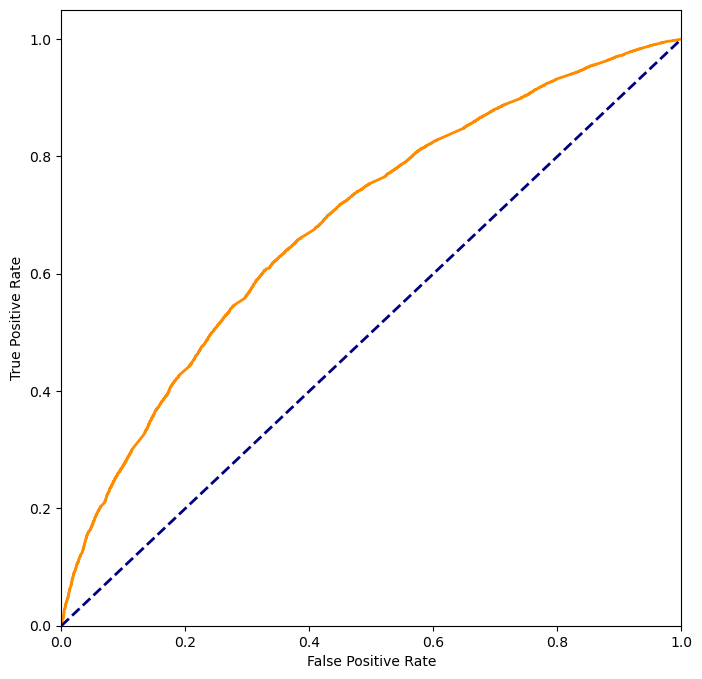

In [138]:
#ROC곡선

predictions = recomm_eval_IBCF.test(testset)

# Convert predictions to true labels (binary: 1 if >= 4, else 0)
y_true = [1 if prediction.r_ui >= 4 else 0 for prediction in predictions]
y_scores = [prediction.est for prediction in predictions]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Getting top K recommendations

In [139]:
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNBasic
from surprise import accuracy

# 최근접 이웃 협업 필터링

# 데이터 분할
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# IBCF 모델 생성
model = KNNBasic(sim_options={'user_based': False})

# 학습
model.fit(trainset)

# 예측 실행
predictions = model.test(testset)

# RMSE을 이용하여 평가
rmse = accuracy.rmse(predictions)
# Recommend items for a specific user (user ID: 1~5)
for i in range(1,6):
    user_id_to_recommend = i
    items_to_recommend = model.get_neighbors(user_id_to_recommend, k=10)

    print(f'Top 10 items to recommend for user {user_id_to_recommend}: {items_to_recommend}')


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9726
Top 10 items to recommend for user 1: [157, 304, 424, 428, 437, 537, 539, 541, 547, 586]
Top 10 items to recommend for user 2: [50, 59, 112, 250, 507, 575, 653, 656, 717, 730]
Top 10 items to recommend for user 3: [30, 59, 64, 190, 205, 210, 250, 254, 332, 439]
Top 10 items to recommend for user 4: [115, 378, 507, 734, 848, 1030, 1078, 1115, 1125, 1151]
Top 10 items to recommend for user 5: [27, 29, 31, 106, 170, 244, 251, 340, 378, 388]
